In [1]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


In [2]:
import pandas as pd
%matplotlib inline

DATA_FOLDER = 'Data/'

INTERVENTIONS_DATASET = DATA_FOLDER+"interventions.csv"
TOPICS_LINKED_DATASET = DATA_FOLDER+"topics_linked.csv"
GLOBAL_MOBILITY_DATASET = DATA_FOLDER+"Global_Mobility_Report.csv"
APPLE_MOBILITY_DATASET = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv"
TIMESERIES_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"

### ***Import wikipedia sum of article for period 20-01-01***

In [25]:
agg = pd.read_json(TIMESERIES_DATASET, compression='gzip')
second_row = agg[['en']].iloc[1]
df = pd.DataFrame(second_row)
dic = df['sum'].iloc[0]

# Transform dic into a DataFrame
df = pd.DataFrame.from_dict(dic, orient='index', columns=['sum'])
df.reset_index(inplace=True)
df.columns = ['date', 'sum']

# Transform the date column to datetime
df['date'] = pd.to_datetime(df['date'])

#period between 2020-01-01 and 2020-06-30
df_wiki_size = df.iloc[730:]
df_wiki_size = df_wiki_size.iloc[:-31,:]
df_wiki_size.reset_index(drop=True, inplace=True)
#df_wiki_size.tail()


,date,sum
177,2020-06-26,76872008
178,2020-06-27,67633187
179,2020-06-28,71683085
180,2020-06-29,84080309
181,2020-06-30,82594664


In [246]:
#normalize the wiki data with respect to the mean
mean_wiki = df_wiki_size['sum'].mean()
normw = ((df_wiki_size['sum'] - mean_wiki) / mean_wiki)
df_wiki_norm = df_wiki_size.copy()
df_wiki_norm['sum'] = normw
df_wiki_norm.rename(columns={'sum': 'norm'}, inplace=True)
df_wiki_norm['date'] = pd.to_datetime(df_wiki['date'])
df_wiki_norm = df_wiki_norm.iloc[:, :].reset_index(drop=True)
df_wiki_norm.head()


,date,norm
0,2020-01-01,-0.248187
1,2020-01-02,-0.022336
2,2020-01-03,-0.020272
3,2020-01-04,-0.154531
4,2020-01-05,-0.091337


### ***Import wikipedia fake news dataset***

In [3]:
excel_file_path = 'Data/realFakeNewsNotLikeVictorsRealShy2.xlsx'

# Correspond to around 320 articles
new_res = pd.read_excel(excel_file_path)

#rename column
new_res.rename(columns={'name': 'Linked_Article'}, inplace=True)

new_res = new_res.drop_duplicates()
new_res.reset_index()

#remove the date for the articles that have a date next to the title
new_res.Linked_Article= new_res.Linked_Article.apply(clean_article_name)
#idea of the type of article
new_res.sample(1)

,mainCategory,subCategory,Linked_Article
65,Deaths and disappearances,Assasination/Suicide theories,Death_of_Salvador_Allende


In [4]:
#Fetch the view count for all available articles
language = "en"
combined_df = fetch_and_combine_pageview_data(language, new_res)

Error fetching data for Aztec,_New_Mexico_crashed_saucer_hoax. Status Code: 404
Error fetching data for Alien_Autopsy_. Status Code: 404
Error fetching data for Conspiracy_theories_about_the_kidnapping_and_murder_of_Aldo_Moro. Status Code: 404
Error fetching data for Alejandro_Castro_. Status Code: 404
Error fetching data for 9/11_conspiracy_theories. Status Code: 404
Error fetching data for LGBT_chemicals_conspiracy_theory. Status Code: 404
Error fetching data for History_of_HIV/AIDS. Status Code: 404
Error fetching data for HIV/AIDS_in_the_United_States. Status Code: 404
Error fetching data for Gamergate_. Status Code: 404
Error fetching data for HIV/AIDS_denialism. Status Code: 404
Error fetching data for Discredited_HIV/AIDS_origins_theories. Status Code: 404
Error fetching data for Tartarian_Empire_. Status Code: 404
Error fetching data for Alaska_payment_conspiracy. Status Code: 404
Error fetching data for Ergenekon_. Status Code: 404
Error fetching data for German_Plot_. Status 

In [10]:
#Create with article name and the view count in function of the date

df_pivoted = combined_df.pivot_table(index='article', columns='timestamp', values='views', aggfunc='mean')

df_pivoted.reset_index(inplace=True)

#merge the data with the article with the corresponding ciews
merged_df = new_res.merge(df_pivoted, left_on='Linked_Article', right_on='article')
merged_df.drop(['subCategory','article' ],axis = 1, inplace=True)

#fill na with 0 
merged_df.fillna(0, inplace=True)

row_sums = merged_df.iloc[:, 2:].sum(axis=1)

# Add the row sums as a new column to the DataFrame 
merged_df['Row_Sums'] = row_sums

Final_consp_sorted = merged_df.sort_values(by='Row_Sums', ascending=False)
#Drop category overview wich is not very relevant
df_without_overview = Final_consp_sorted[Final_consp_sorted['mainCategory'] != 'Overview']
df_without_overview = df_without_overview.iloc[:,:-667]
df_without_overview.sample(1)



,mainCategory,Linked_Article,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,...,2021-07-25 00:00:00,2021-07-26 00:00:00,2021-07-27 00:00:00,2021-07-28 00:00:00,2021-07-29 00:00:00,2021-07-30 00:00:00,2021-07-31 00:00:00,2021-08-01 00:00:00,2021-08-02 00:00:00,2021-08-03 00:00:00
128,Gender and sexuality,Anti-LGBT_rhetoric,118.0,109.0,134.0,147.0,145.0,143.0,150.0,227.0,...,168.0,186.0,203.0,215.0,242.0,207.0,170.0,202.0,218.0,186.0


### **Isolated cell to find the most popular artcicle for dates that have a pic in fake news.**

In [158]:
column_163 = df_without_overview.iloc[:, 505].head()

#get the value and position of the 3 highest values
max_value = column_163.max()
max_index = column_163.idxmax()

# get the value and position of the second highest value
second_max_value = column_163.nlargest(2).iloc[-1]
second_max_index = column_163.nlargest(2).index[-1]

#get the third highest value 
   
third_max_value = column_163.nlargest(3).iloc[-1]
third_max_index = column_163.nlargest(3).index[-1]

print(max_index)
print(max_value)
print(second_max_index)
print(second_max_value)
print(third_max_index)
print(third_max_value)


#print(column_163)
df_without_overview.loc[214,:]
#df_without_overview.iloc[:, 505].head()

249
28918.0
247
13419.0
214
10695.0


mainCategory                   Regional
Linked_Article         Grigori_Rasputin
2019-01-01 00:00:00              6812.0
2019-01-02 00:00:00              6636.0
2019-01-03 00:00:00              7199.0
                             ...       
2021-07-30 00:00:00              5820.0
2021-07-31 00:00:00              6535.0
2021-08-01 00:00:00              6424.0
2021-08-02 00:00:00              6371.0
2021-08-03 00:00:00              5901.0
Name: 214, Length: 948, dtype: object

In [11]:
#Aggregate using median
#for this need to drop the article name and the main category
df_med = df_without_overview.drop(['Linked_Article', 'mainCategory'], axis=1)
agg_data_median = df_med.median()

#Aggregate using mean
#aggregated_data = df_without_overview.groupby('mainCategory').sum()




In [128]:
#if we use median
df_fake = agg_data_median.reset_index()
df_fake.columns = ['date', 'sum']
df_fake['date'] = pd.to_datetime(df_fake['date'])


#if we use mean

#df_transposed = aggregated_data.iloc[:,:-3].transpose()
#sum_all_categories = df_transposed.sum(axis=1)
#df_fake = sum_all_categories.reset_index()
#df_fake.columns = ['date', 'sum']
#df_fake['date'] = pd.to_datetime(df['date'])
#df_fake.tail()

#Take period 1st of January 2020 to 30st of june 2019
df_fake_size = df_fake.iloc[ 365:-399,:].reset_index(drop=True)



In [129]:
#normalize the wiki fake news data with respect to the mean
mean_fake = df_fake_size['sum'].mean()
normf= ((df_fake_size['sum']- mean_fake)/ mean_fake)
df_fake_norm = df_fake_size.copy()
df_fake_norm['sum'] = normf
df_fake_norm.rename(columns={'sum': 'norm'}, inplace=True)
df_fake_norm['date'] = pd.to_datetime(df_fake_norm['date'])
df_fake_norm.tail()

,date,norm
177,2020-06-26,-0.126353
178,2020-06-27,-0.126353
179,2020-06-28,-0.126353
180,2020-06-29,-0.009867
181,2020-06-30,-0.106939


### **Difference between normalised wiki views for all article and for fake news**


In [131]:
df_diff = pd.DataFrame({'date': df_fake_norm['date'], 'sum_diff': df_fake_norm['norm'] - df_wiki_norm['norm']})
df_diff.tail()


,date,sum_diff
177,2020-06-26,0.073342
178,2020-06-27,0.169526
179,2020-06-28,0.127363
180,2020-06-29,0.114783
181,2020-06-30,0.033179


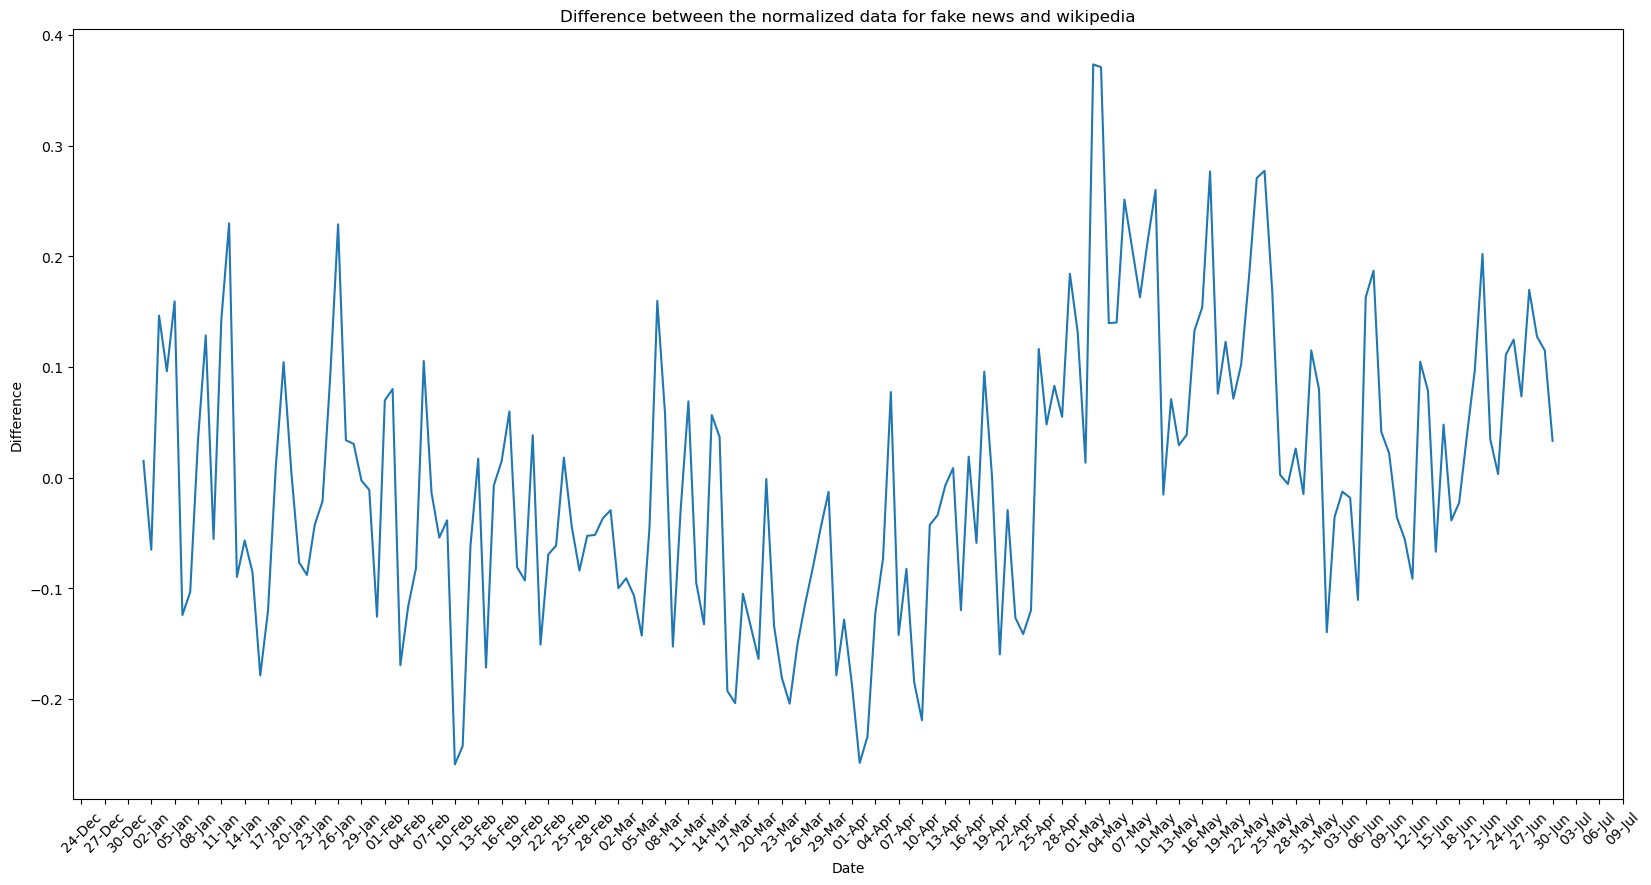

In [132]:
import matplotlib.dates as mdates

# Plot the difference between the normalized data for fake news and wikipedia
plt.figure(figsize=(20,10))
plt.plot(df_diff['date'], df_diff['sum_diff'])
plt.title('Difference between the normalized data for fake news and wikipedia')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.show()



**Moving average to make curve smoother**

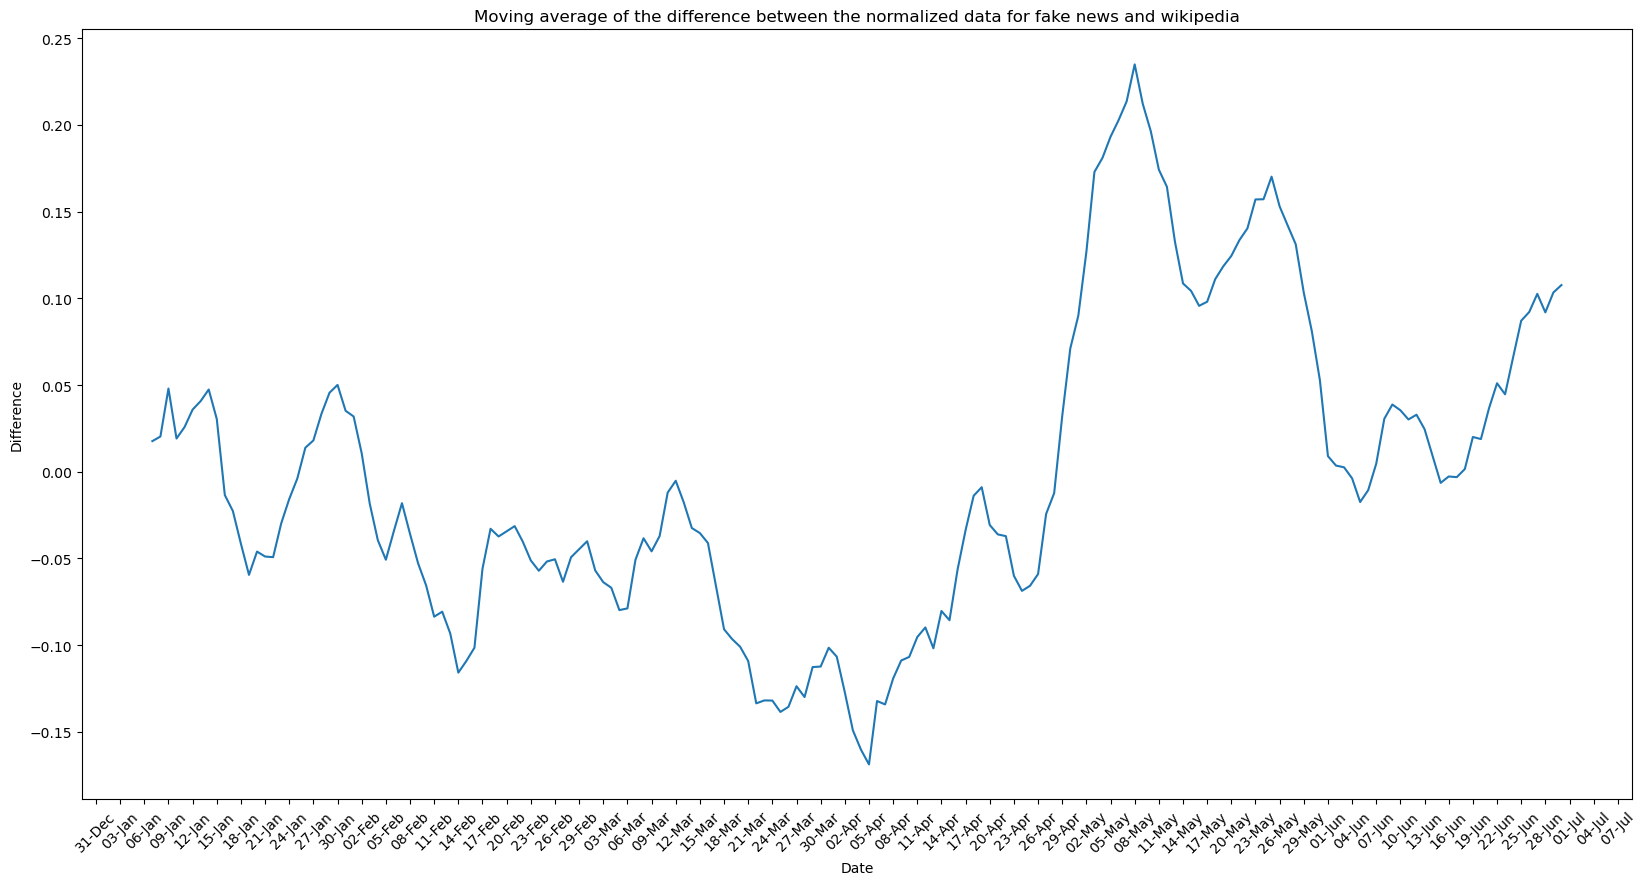

In [133]:
window_size = 7  # Define the window size for the moving average
df_diff['moving_average'] = df_diff['sum_diff'].rolling(window=window_size).mean()
#plot the moving average
plt.figure(figsize=(20,10))
plt.plot(df_diff['date'], df_diff['moving_average'])
plt.title('Moving average of the difference between the normalized data for fake news and wikipedia')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.show()


In [283]:
#df_diff.drop('moving_average', axis=1, inplace=True)
#df_diff to datetime
df_diff['date'] = pd.to_datetime(df_diff['date'])
df_diff.tail(1)



KeyError: 'date'

### **Difference in difference analysis.**

In [140]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 


# Filter data for 50 days before and after March 14, 2020
start_date = pd.to_datetime("2020-02-01")
treatment_start_date = pd.to_datetime("2020-03-12")
treatment_end_date = treatment_start_date + pd.Timedelta(days=42)

# control group data
df_control = df_diff[(df_diff['date'] <= treatment_start_date) & (df_diff['date'] >= start_date)]
df_control.reset_index(drop=True, inplace=True)

# treatment group data
df_treatment = df_diff[(df_diff['date'] >= treatment_start_date) & (df_diff['date'] <= treatment_end_date)]
df_treatment.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment['treatment'] = 1
df_control ['treatment'] = 0

df_concatenated = pd.concat([df_control, df_treatment], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()

# Print regression results
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     5.983
Date:                Sun, 17 Dec 2023   Prob (F-statistic):             0.0166
Time:                        19:40:42   Log-Likelihood:                 85.062
No. Observations:                  84   AIC:                            -166.1
Df Residuals:                      82   BIC:                            -161.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0499      0.014     -3.591      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21996\1395782080.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment['treatment'] = 1
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21996\1395782080.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control ['treatment'] = 0


Statisticly significant p-value < 0.05. However increase compared to average of wikipedia article is small R-squared = 0.068



## **Now we download victor Covid fake news to compare with wikipedia baseline**

In [252]:
source  = "Data/"
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()
wiki_pages_links.sample(1)

,Sub-subheading,Subheading,Main Heading,Links,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1569,Unnamed: 1570,Unnamed: 1571,Unnamed: 1572,Unnamed: 1573,Unnamed: 1574,Unnamed: 1575,Unnamed: 1576,Unnamed: 1577,Unnamed: 1578
40,Cruise ships as safe havens,Cruise ships as safe havens,Disease spread,"['/wiki/COVID-19_pandemic_on_cruise_ships', '/...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
language = "en"
articles_list = ["Covid-19"]
result=fetch_pageview_count(language, articles_list)
print(result)

{'Covid-19':            project   article granularity  timestamp      access agent  views
0     en.wikipedia  Covid-19       daily 2020-02-11  all-access  user    710
1     en.wikipedia  Covid-19       daily 2020-02-12  all-access  user    555
2     en.wikipedia  Covid-19       daily 2020-02-13  all-access  user    487
3     en.wikipedia  Covid-19       daily 2020-02-14  all-access  user   1135
4     en.wikipedia  Covid-19       daily 2020-02-15  all-access  user   1109
...            ...       ...         ...        ...         ...   ...    ...
1201  en.wikipedia  Covid-19       daily 2023-05-27  all-access  user     38
1202  en.wikipedia  Covid-19       daily 2023-05-28  all-access  user     35
1203  en.wikipedia  Covid-19       daily 2023-05-29  all-access  user     46
1204  en.wikipedia  Covid-19       daily 2023-05-30  all-access  user     68
1205  en.wikipedia  Covid-19       daily 2023-05-31  all-access  user     44

[1206 rows x 7 columns]}


In [177]:

import ast
wiki_pages_links = pd.read_csv(source+"covid-19_misinformation5.csv").copy()

#Filtering misinformation with the selected clusters
word_cluster_1= "Virus origin" 
word_cluster_2= "Disease spread"
word_cluster_3= "Prevention and treatment"
word_cluster_4= "Mortality"
word_cluster_5= "Other"

wiki_cluster_links_1 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_1))].copy()
wiki_cluster_links_2 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_2))].copy()
wiki_cluster_links_3 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_3))].copy()
wiki_cluster_links_4 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_4))].copy()
wiki_cluster_links_5 = wiki_pages_links[(wiki_pages_links["Main Heading"].str.contains(word_cluster_5))].copy()

# Cleaning the clusters to only obtain words searcheable in wikipedia API
def extract_clean_text(links):
    cleaned_links = []
    for link in links:
        if '/wiki/' in link:
            extracted_text = link.split('/wiki/')[1].split('#')[0].replace('_', ' ')
            cleaned_links.append(extracted_text)
    return cleaned_links

# Convert string representation of list to actual list using ast.literal_eval and apply the function

wiki_cluster_links_1["Cleaned_Text"] = wiki_cluster_links_1["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_2["Cleaned_Text"] = wiki_cluster_links_2["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_3["Cleaned_Text"] = wiki_cluster_links_3["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_4["Cleaned_Text"] = wiki_cluster_links_4["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))
wiki_cluster_links_5["Cleaned_Text"] = wiki_cluster_links_5["Links"].apply(lambda x: extract_clean_text(ast.literal_eval(x)))


0    [COVID-19 lab leak theory, Severe acute respir...
1    [Israeli secret service, The Washington Times,...
2    [Gain-of-function research, Angela Rasmussen, ...
3      [Tedros Adhanom Ghebreyesus, Science (journal)]
4    [Health Canada, Public Health Agency of Canada...
Name: Cleaned_Text, dtype: object

In [183]:
# Looking for all the articles in the cluster 1 which correspond to Virus Origin 

list_cluster_1 = list(wiki_cluster_links_1["Cleaned_Text"])
list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
language      = "en"
final_count_1 =[]
for i in list_cluster_1:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_1.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 2 which correspond to Spread

list_cluster_2 = list(wiki_cluster_links_2["Cleaned_Text"])
del list_cluster_2[7] # Outlier - this element has an empty list that doesn't allow to concatenate the data frame
final_count_2 =[]
for i in list_cluster_2:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_2.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 3 which correspond to Prevention and Treatment
list_cluster_3 = list(wiki_cluster_links_3["Cleaned_Text"])
final_count_3 =[]
for i in list_cluster_3:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_3.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 4 which correspond to Mortality
list_cluster_4 = list(wiki_cluster_links_4["Cleaned_Text"])
final_count_4 =[]
for i in list_cluster_4:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_4.append(pd.DataFrame(merged_df))

# Looking for all the articles in the cluster 5 which correspond to Other
list_cluster_5 = list(wiki_cluster_links_5["Cleaned_Text"])
final_count_5 =[]
for i in list_cluster_5:
    results   = fetch_pageview_count(language, i)
    merged_df = pd.concat(results, ignore_index=True)
    #Grouping by date the dataframe to sum up the views
    merged_df = merged_df.groupby(['timestamp'])["views"].sum()
    final_count_5.append(pd.DataFrame(merged_df))




Error fetching data for 5G misinformation. Status Code: 404


In [207]:
if final_count_1:
    final_views_1 = pd.concat(final_count_1, ignore_index=False)
else:
    final_views_1 = pd.DataFrame()

if final_count_2:
    final_views_2 = pd.concat(final_count_2, ignore_index=False)
else:
    final_views_2 = pd.DataFrame()

if final_count_3:
    final_views_3 = pd.concat(final_count_3, ignore_index=False)
else:
    final_views_3 = pd.DataFrame()

if final_count_4:
    final_views_4 = pd.concat(final_count_4, ignore_index=False)
else:
    final_views_4 = pd.DataFrame()

if final_count_5:
    final_views_5 = pd.concat(final_count_5, ignore_index=False)
else:
    final_views_5 = pd.DataFrame()


In [213]:
final_views_3.head()

""


In [215]:
# Grouping the new data frame to get the final number of visits
data_1 = final_views_1.groupby(['timestamp']).sum()
data_2 = final_views_2.groupby(['timestamp']).sum()
#data_3 = final_views_3.groupby(['timestamp']).sum()
#data_4 = final_views_4.groupby(['timestamp']).sum()
data_5 = final_views_5.groupby(['timestamp']).sum()

In [223]:

df = pd.DataFrame()
df['views'] = data_1['views'] + data_2['views'] + data_5['views']
df_covid = df.iloc[365:]
df_covid = df_covid.iloc[:-1065,:]
df_covid.tail()


,views
timestamp,
2020-06-26,765891
2020-06-27,812559
2020-06-28,862460
2020-06-29,825739
2020-06-30,839480


In [225]:
df = pd.DataFrame()
df['views'] = data_1['views'] + data_2['views'] + data_5['views']
df_covid = df.iloc[365:]
df_covid = df_covid.iloc[:-1065,:]

df_covid.tail()


,views
timestamp,
2020-06-26,765891
2020-06-27,812559
2020-06-28,862460
2020-06-29,825739
2020-06-30,839480


### **Normalised value of the sum of covid fake news wikipedia article**

In [256]:
import pandas as pd

# Normalize df covid with respect to the mean
mean = df_covid['views'].mean()
df_covid_normalized = (df_covid['views'] - mean) / mean

# Create a new dataframe with columns 'date' and 'norm'
df_normalized = pd.DataFrame({'date': df_covid.index, 'norm': df_covid_normalized})



df_normalized.head()




,date,norm
timestamp,,
2020-01-01,2020-01-01,-0.589463
2020-01-02,2020-01-02,-0.536040
2020-01-03,2020-01-03,-0.291709
2020-01-04,2020-01-04,-0.345731
2020-01-05,2020-01-05,-0.341275


Plot of the increase in Covid attention compared to wikipedia attention

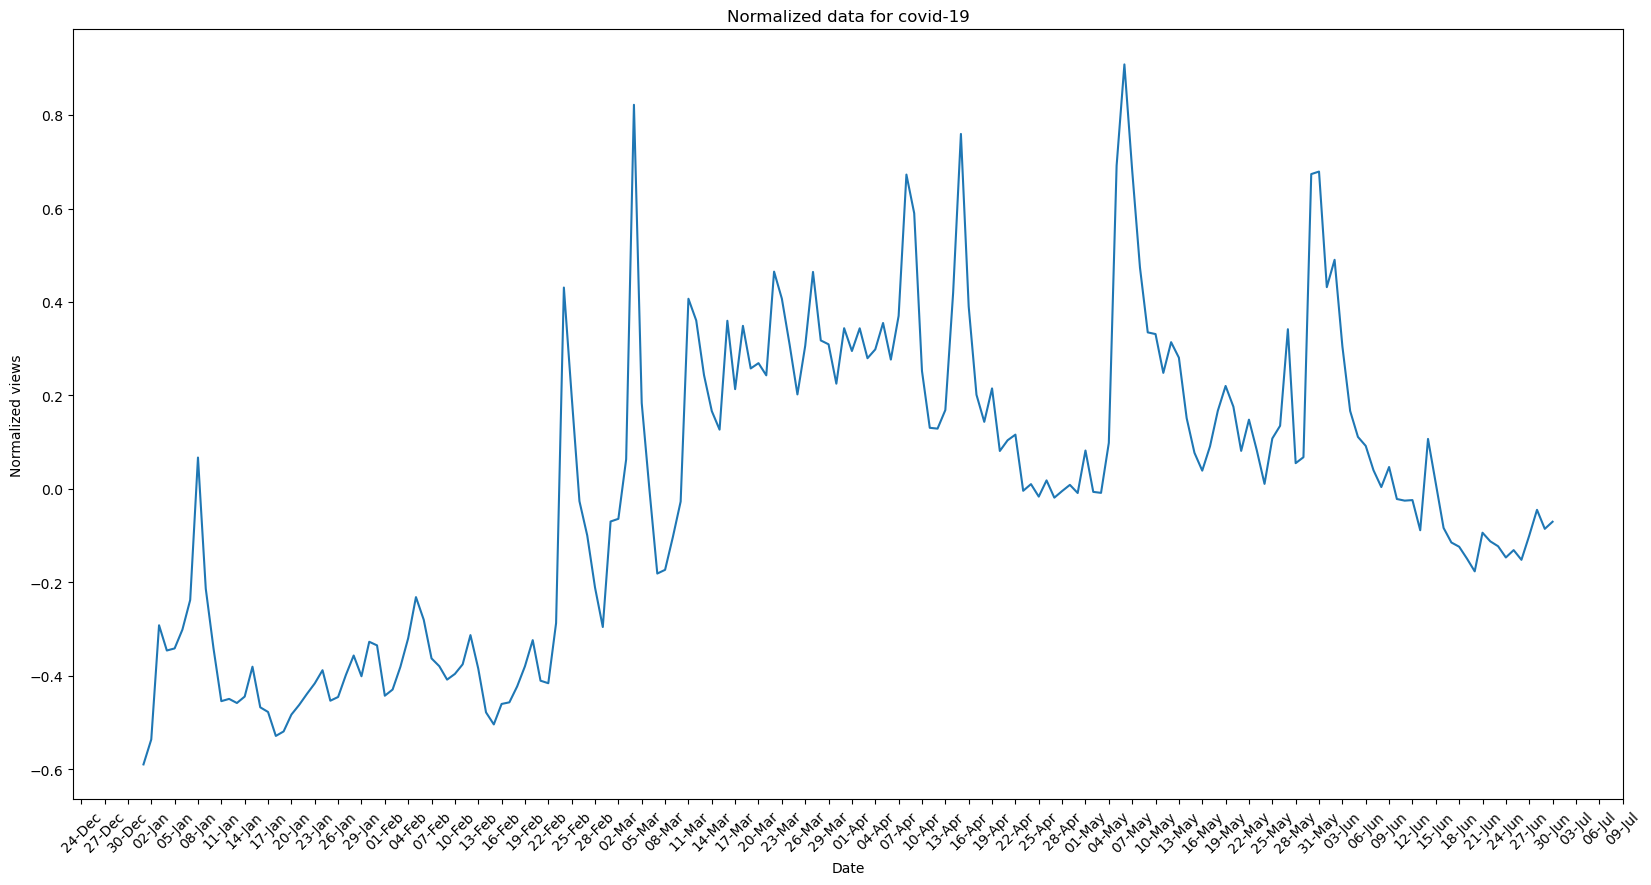

In [229]:
#plot the normalized data
plt.figure(figsize=(20,10))
plt.plot(df_covid_normalized)
plt.title('Normalized data for covid-19')
plt.xlabel('Date')
plt.ylabel('Normalized views')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set the x-axis tick interval to show every 7 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Format the x-axis tick labels to show day and month
plt.show()

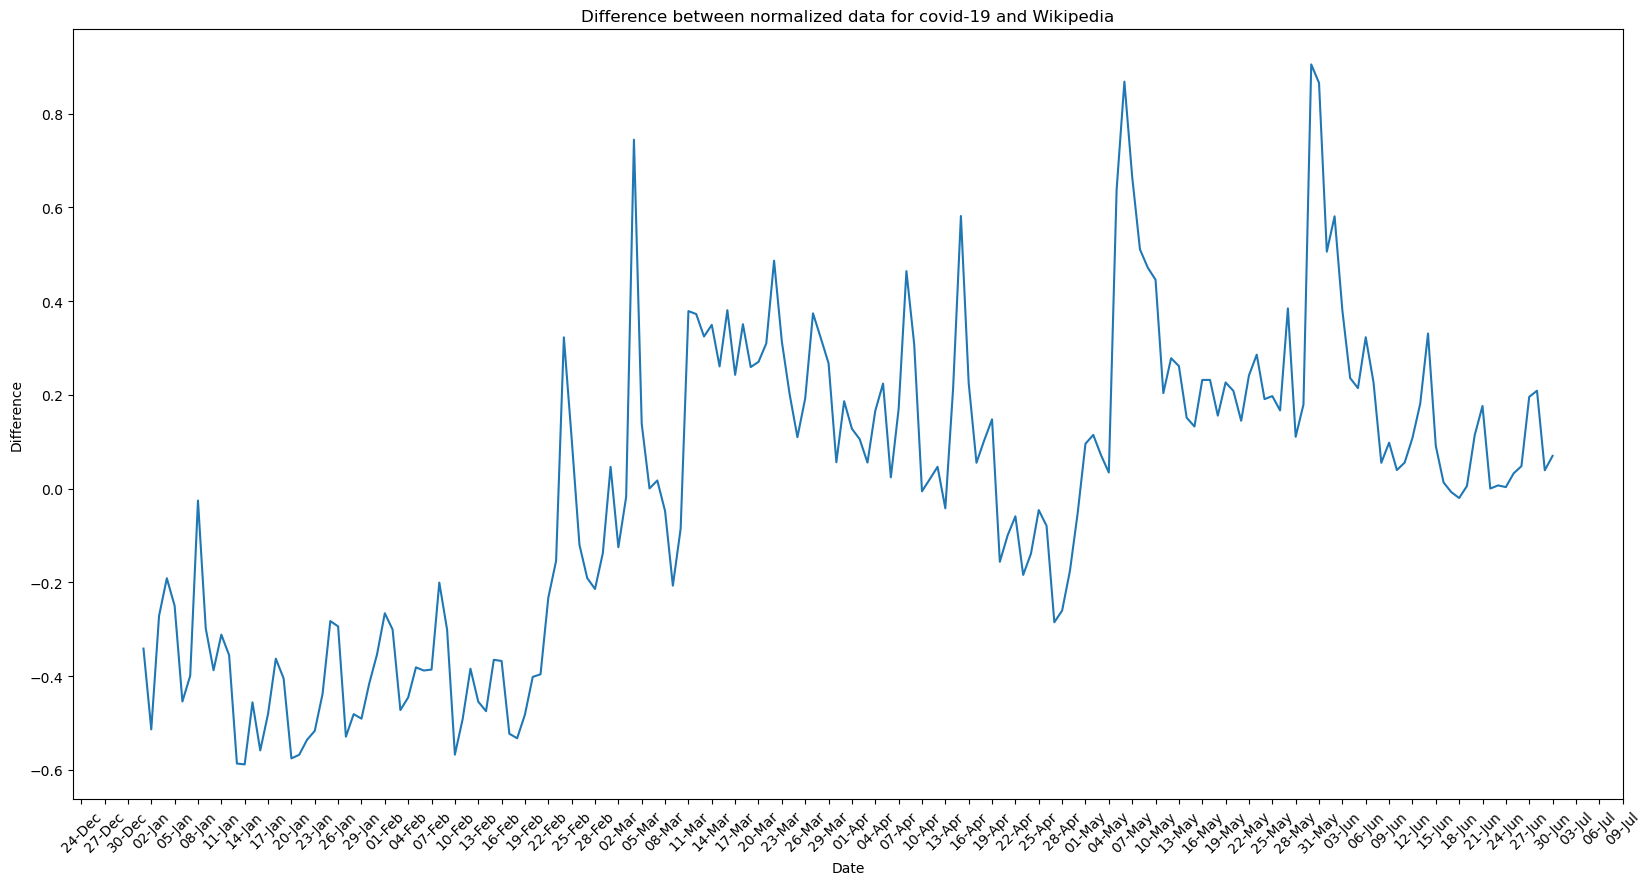

In [269]:
df_diff_covid = pd.DataFrame({'date': df_wiki_norm.reset_index()['date'], 'sum_diff': df_normalized.reset_index()['norm'] - df_wiki_norm.reset_index()['norm']})

# Plot the difference
plt.figure(figsize=(20,10))
plt.plot(df_diff_covid['date'], df_diff_covid['sum_diff'])
plt.title('Difference between normalized data for covid-19 and Wikipedia')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()


In [277]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import Timedelta 

# Filter data for 50 days before and after March 14, 2020
start_date = pd.to_datetime("2020-02-01")
treatment_start_date = pd.to_datetime("2020-03-12")
treatment_end_date = treatment_start_date + pd.Timedelta(days=42)

# control group data
df_control = df_diff_covid[(df_diff_covid['date'] <= treatment_start_date) & (df_diff_covid['date'] >= start_date)]
df_control.reset_index(drop=True, inplace=True)

# treatment group data
df_treatment = df_diff_covid[(df_diff_covid['date'] >= treatment_start_date) & (df_diff_covid['date'] <= treatment_end_date)]
df_treatment.reset_index(drop=True, inplace=True)

# Add treatment and post-treatment columns
df_treatment['treatment'] = 1
df_control ['treatment'] = 0

df_concatenated = pd.concat([df_control, df_treatment], ignore_index=True)

# Fit the model
model = smf.ols(formula='sum_diff ~ treatment', data=df_concatenated).fit()
#model = smf.ols(formula='sum_diff ~ treatment + C(date) + treatment:C(date)', data=df_concatenated).fit()


# Print regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               sum_diff   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     55.17
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           9.39e-11
Time:                        21:19:54   Log-Likelihood:                 2.8703
No. Observations:                  84   AIC:                            -1.741
Df Residuals:                      82   BIC:                             3.121
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1948      0.037     -5.269      0.0

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21996\1230754740.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment['treatment'] = 1
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21996\1230754740.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control ['treatment'] = 0


Stastistically significant as p<.05, R-squared = 0.40 and 

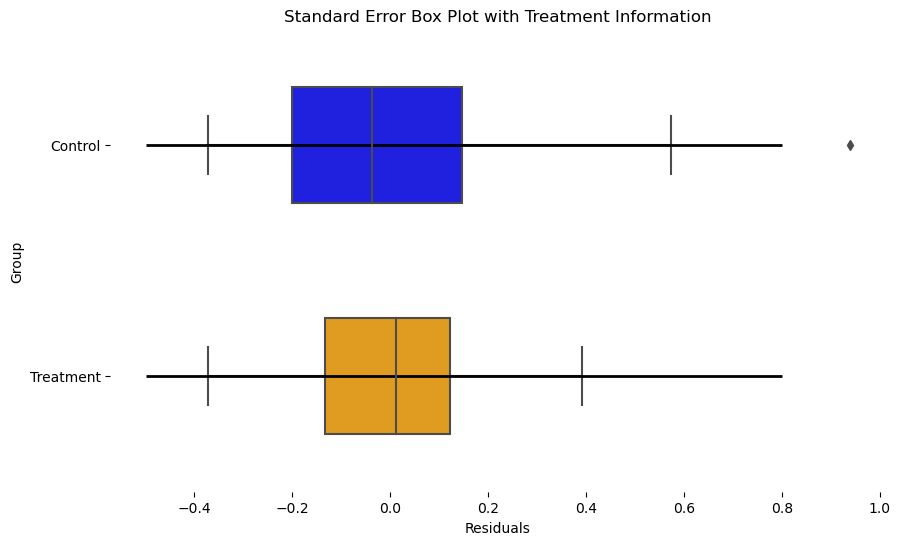

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract residuals from the regression results
residuals = model.resid

# Create a new DataFrame to include treatment information
df_plot = pd.DataFrame({'Residuals': residuals, 'Treatment': df_concatenated['treatment']})

# Plot standard error box plot with treatment information
plt.figure(figsize=(10, 6))
sns.boxplot(x='Residuals', y='Treatment', data=df_plot, width=0.5, orient='h', palette={0: 'blue', 1: 'orange'})
sns.despine(left=True, bottom=True)

# Add median lines for each group
medians = df_plot.groupby('Treatment')['Residuals'].median().values
for i, median in enumerate(medians):
    plt.hlines(y=i, xmin=-0.5, xmax=0.8, color='black', linestyle='-', linewidth=2)

plt.title('Standard Error Box Plot with Treatment Information')
plt.xlabel('Residuals')
plt.ylabel('Group')
plt.yticks([0, 1], ['Control', 'Treatment'])
plt.show()


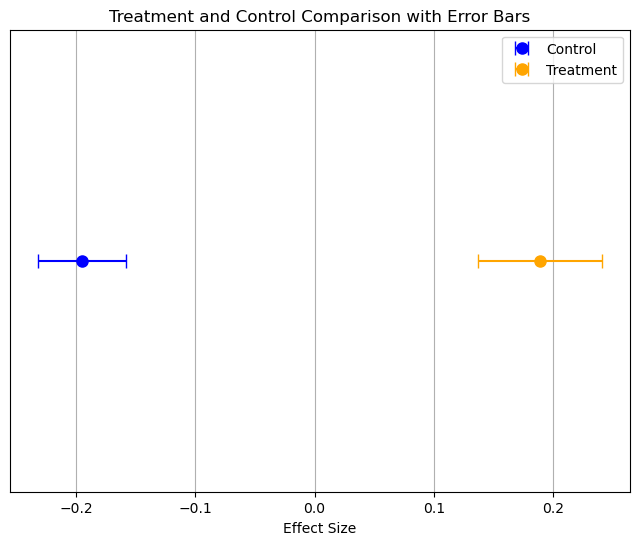

In [282]:

# Coefficients and standard errors from the regression results
intercept_coef = -0.1948
treatment_coef = 0.3837
intercept_std_err = 0.037
treatment_std_err = 0.052

# Sample data for treatment and control
control_mean = intercept_coef
treatment_mean = intercept_coef + treatment_coef

# Plotting
plt.figure(figsize=(8, 6))

# Plotting error bars for control
plt.errorbar(
    x=control_mean,
    y=0,
    xerr=intercept_std_err,
    fmt='o',
    label='Control',
    color='blue',  # Choose your desired color
    capsize=5,  # Adjust capsize for better visibility of error bars
    markersize=8,  # Adjust markersize for better visibility
)

# Plotting error bars for treatment
plt.errorbar(
    x=treatment_mean,
    y=0,
    xerr=treatment_std_err,
    fmt='o',
    label='Treatment',
    color='orange',  # Choose your desired color
    capsize=5,  # Adjust capsize for better visibility of error bars
    markersize=8,  # Adjust markersize for better visibility
)

plt.xlabel('Effect Size')
plt.yticks([])  # Remove y-axis ticks
plt.title('Treatment and Control Comparison with Error Bars')
plt.legend()

plt.grid(True)
plt.show()
